In [158]:
from matplotlib.animation import PillowWriter
import matplotlib.animation as animation
from matplotlib import pyplot as plt
from scipy.io.wavfile import read
from scipy import signal, stats
from decimal import *
from cmath import *
import numpy as np
import cProfile
import ipytest
import random
import pytest
import math
ipytest.config(rewrite_asserts=True, magics=True)
__filename__ = "XC"

In [159]:
def stereo_to_mono(audio):
    return audio.sum(axis=1) / 2

In [160]:
frq, raw_sample = read("oblivion.wav")
original = stereo_to_mono(raw_sample)

In [161]:
frq, raw_sample = read("oblivion.cut.wav")
sample = stereo_to_mono(raw_sample)

In [162]:
noise = np.random.normal(0, 1, sample.shape)
len(noise)

959488

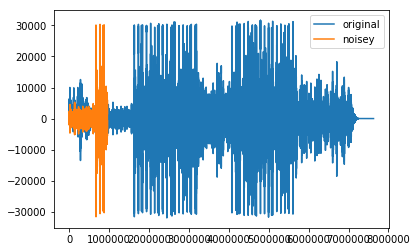

In [163]:
original_l, = plt.plot(original, label="original")
sample_l, = plt.plot(sample + noise, label="noisey sample")
plt.legend([original_l, sample_l], ["original", "noisey"])
plt.show()

In [164]:
class AudioClip(object):
    def __init__(self, data, frq):
        self.data = data
        self.frq = frq
        
    def __get_item__(self, i):
        return self.data[i]
    
    def low_pass(self, cutoff_frq, nyq_freq, order=4):
        normal_cutoff = float(cutoff_frq) / nyq_freq
        b, a = signal.butter(order, normal_cutoff, btype='lowpass', output='ba')
        y = signal.filtfilt(b, a, self.data)
        self.data = y
    
    def filter_and_downsample(self, ds_factor=4):
        self.data = signal.decimate(self.data, ds_factor, n=4)
        self.frq = self.frq / ds_factor
    
#     def create_window(self, bin_num, total_width, seconds=0.1):
#         bin_size = int(self.frq * seconds)
#         frame = np.hanning(bin_size)
#         left_pad = np.zeros(bin_num * bin_size)
#         right_pad = np.zeros(total_width - ((bin_num + 1) * bin_size))
#         window = np.concatenate((left_pad, frame, right_pad), axis=0)
#         return window
    
#     def apply_window(self, bin_num):
#         window = self.create_window(bin_num, len(data))
#         return self.data * window
    
#     def zero_pad(self, records):
#         x = len(records)
#         zeroes = pow(2, math.ceil(math.log(x) / math.log(2))) - x
#         return np.concatenate((records, [0] * zeroes))
    def get_snippet(self, bin_num, bin_size):
        # For sampling frequency 12kHz and 0.1s window
        # bin 0 should return 0 through 1199
        # bin 1 should return 1200 through 2400
        idx = bin_num * bin_size
        snippet = self.data[idx:idx+bin_size]
        assert len(snippet) == bin_size
        return snippet
    
    def multiply_hamming(self, snippet, bin_size):
        # Better than hanning window
        # plt.plot(np.hanning(bin_size) * np.array(snippet))
        return np.hamming(bin_size) * np.array(snippet)
    
    def discard_symmetry(self, frequencies):
        half = len(frequencies) // 2
        return frequencies[:half]
    
    def create_frequencies_array(self, bin_seconds=0.1):
        bin_size = int(self.frq * bin_seconds)
        num_bins = len(self.data) // bin_size
        results = []
        windowed_snippets = []
        magnitudes = []
        for b in range(num_bins):
            # values = apply_window(data, frq, bin_num)
            # padded_values = zero_pad(values)
            # padding gives you better resolution, but too expensive
            # more spectral leakage w/o padding
            snippet = self.get_snippet(b, bin_size)
            windowed_snippet = self.multiply_hamming(snippet, bin_size)
            windowed_snippets.append(windowed_snippet)
            # Can also use Hermitian to speed up
            transform = self.discard_symmetry(np.fft.fft(windowed_snippet))
            results.append(transform)
            magnitude = [abs(x) for x in transform]
            magnitudes.append(magnitude)
            print(b)
        return magnitudes, windowed_snippets, results
    
    def __str__(self):
        return "Size %d sampled at %d Hz" % (len(self.data), self.frq)

In [165]:
ac = AudioClip(original, frq)
print(ac)
ac.low_pass(5000, 2 * 5000) # Cut at 5kHz
ac.filter_and_downsample()

Size 7627232 sampled at 48000 Hz


/Users/kitty/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/kitty/miniconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [166]:
print(ac)

Size 1906808 sampled at 12000 Hz


In [167]:
magnitudes, windowed_snippets, results = ac.create_frequencies_array()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1589 600


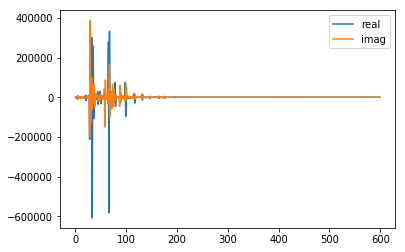

In [168]:
# Frequency went from 44.1kHz to 11.025kHz
print(len(results), len(results[0]))
np.mean(results[1500])
plt.plot([x.real for x in results[701]])
plt.plot([x.imag for x in results[701]])
plt.legend(['real', 'imag'])
plt.show()

In [169]:
def create_gif(file, title, results, xlabel="", ylabel=""):
    ims = []
    fig = plt.figure()
    plt.gca().set_title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    color = random.randint(50, 200) / 255, random.randint(50, 200) / 255, random.randint(50, 200) / 255
    for result in results:
        ims.append(plt.plot(result, color=color))
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=500, repeat=True)
    writer = PillowWriter(fps=50)
    ani.save(file, writer=writer)
    plt.show()

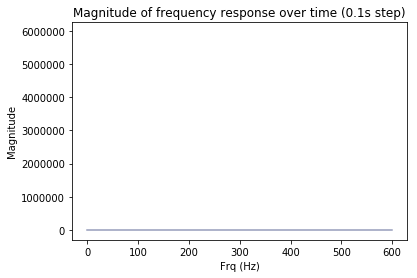

In [14]:
create_gif("magnitude.gif", "Magnitude of frequency response over time (0.1s step)", magnitudes, xlabel="Frq (Hz)", ylabel="Magnitude")

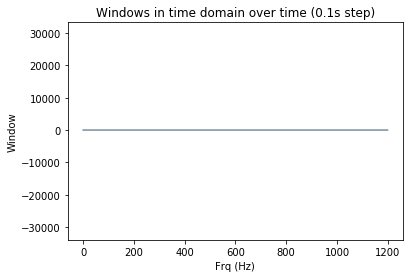

In [15]:
create_gif("windowed.gif", "Windows in time domain over time (0.1s step)", windowed_snippets, xlabel="Frq (Hz)", ylabel="Window")

/Users/kitty/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


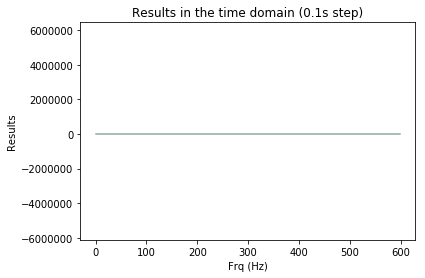

In [241]:
create_gif("results.gif", "Results in the time domain (0.1s step)", results, xlabel="Frq (Hz)", ylabel="Results")

In [417]:
class Spectrogram:
    def __init__(self, frq, data):
        self.frq = frq
        self.data = data
        self.bins = []
        self.populate()
        
    def populate(self):
        all_bins = []
        for d in self.data:
            all_bins.append(FrequencyBin(self.frq, d))
        self.bins = self.get_loud_bins(all_bins)
            
    def print_bins(self):
        for b in self.bins:
            print(b.save_above_threshold(), b.calc_threshold(b.get_max_per_level()))
            
    def get_loud_bins(self, all_bins):
        return [b.save_above_threshold() for b in all_bins]
    
    def make_pairs_dict(self, title, artist):
        pairs = {}
        for address in self.get_addresses():
            pairs[address] = title, artist
        return pairs
    
    def get_addresses(self, anchor_lead=3, target_size=5, precision=7):
        decimal.getcontext().prec = precision
        decimal.getcontext().rounding = ROUND_HALF_DOWN
        ordering = self.get_bin_ordering()
        addresses = []
        for a in range(len(self.bins) - anchor_lead - target_size):
            anchor_time = ordering[a][0]
            anchor_frq = ordering[a][1]
            t_0 = a + anchor_lead
            for target in ordering[t_0:t_0+target_size]:
                target_time = target[0]
                target_frq = target[1]
                delta_t = target_time - anchor_time
                addresses.append((anchor_frq, target_frq, delta_t, anchor_time))
        return addresses

    def get_bin_ordering(self):
        ordering = []
        for f, bin_nums in zip([x / 10.0 for x in range(0, len(self.bins))], self.bins):
            for bin_num in bin_nums:
                x = Decimal(f).quantize(Decimal('0.1'))
                y = Decimal(bin_num * (12000 / 600)).quantize(Decimal('0.1')) # Multiply by 20
                ordering.append((x, y))
        return ordering

In [418]:
class FrequencyBin:
    def __init__(self, frq, frequencies):
        self.frq = frq
        self.frequencies = frequencies
        # Cut offs depend on numbins (from frq)
        self.L1 = 10
        self.L2 = 20
        self.L3 = 40
        self.L4 = 80
        self.L5 = 160
        self.points = self.save_above_threshold()
        
    def get_max_per_level(self):
        M1, M2, M3, M4, M5, M6 = 0, 0, 0, 0, 0, 0
        i1, i2, i3, i4, i5, i6 = 0, 0, 0, 0, 0, 0
        for i, x in enumerate(self.frequencies):
            if i < self.L1:
                if x > M1:
                    i1, M1 = i, x
            elif i < self.L2:
                if x > M2:
                    i2, M2 = i, x
            elif i < self.L3:
                if x > M3:
                    i3, M3 = i, x
            elif i < self.L4:
                if x > M4:
                    i4, M4 = i, x
            elif i < self.L5:
                if x > M5:
                    i5, M5 = i, x
            else:
                if x > M6:
                    i6, M6 = i, x
        i = [i1, i2, i3, i4, i5, i6]
        M = [M1, M2, M3, M4, M5, M6]
        return i, M
                
    def calc_threshold(self, max_per_level, abs_threshold=1, alpha=2):
        self.mean = np.mean(max_per_level)
        return max(self.mean * alpha, abs_threshold)
    
    def save_above_threshold(self):
        bin_per_level, max_per_level = self.get_max_per_level()
        threshold = self.calc_threshold(max_per_level)
        points = [i for i, M in zip(bin_per_level, max_per_level) if M > threshold]
        return points

In [419]:
def create_spectrogram(file, bins):
    X = []
    Y = []
    for x, bin_nums in zip([x / 10.0 for x in range(0, len(bins))], bins):
        for bin_num in bin_nums:
            y = bin_num * (12000 / 600) # Multiply by 20
            X.append(x)
            Y.append(y)
    plt.scatter(X, Y, s=0.5)
    plt.title(file)
    plt.xlabel("Time (s)")
    plt.ylabel("Frq (Hz)")
    plt.savefig(file)
    return len(X)

1767

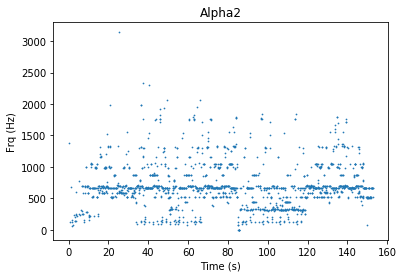

In [420]:
s = Spectrogram(12000, magnitudes)
create_spectrogram("Alpha2", s.bins)

nfft = 512
Pxx, freqs, bins, image = plt.specgram(original, Fs=12000, NFFT=nfft, window=np.hamming(nfft), noverlap=2)

In [421]:
def create_spec_gif(file, title, xlabel, ylabel, results):
    ims = []
    fig = plt.figure()
    plt.gca().set_title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    i = 0
    for result in results:
        Pxx, freqs, bins, image = plt.specgram(result, Fs=12000, NFFT=512, window=np.hamming(512), noverlap=2)
        ims.append([image])
        print(image, i)
        i += 1
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=500, repeat=True)
    writer = PillowWriter(fps=50)
    ani.save(file, writer=writer)
    plt.show()

In [422]:
p = s.make_pairs_dict("oblivion", "lily potter")
p

{(Decimal('1380.0'),
  Decimal('120.0'),
  Decimal('1.5'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('1380.0'),
  Decimal('60.0'),
  Decimal('1.7'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('1380.0'),
  Decimal('160.0'),
  Decimal('1.8'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('1380.0'),
  Decimal('80.0'),
  Decimal('2.0'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('1380.0'),
  Decimal('240.0'),
  Decimal('2.8'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('60.0'),
  Decimal('1.1'),
  Decimal('0.6')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('160.0'),
  Decimal('1.2'),
  Decimal('0.6')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('80.0'),
  Decimal('1.4'),
  Decimal('0.6')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('240.0'),
  Decimal('2.2'),
  Decimal('0.6')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('140.0'),
  Dec

In [423]:
import sys
sys.getsizeof(p)

295008

In [424]:
decimal.getcontext()

Context(prec=7, rounding=ROUND_HALF_DOWN, Emin=-999999, Emax=999999, capitals=1, clamp=0, flags=[Inexact, InvalidOperation, FloatOperation, Rounded], traps=[InvalidOperation, DivisionByZero, Overflow])

In [425]:
print(len(p))
p

7905


{(Decimal('1380.0'),
  Decimal('120.0'),
  Decimal('1.5'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('1380.0'),
  Decimal('60.0'),
  Decimal('1.7'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('1380.0'),
  Decimal('160.0'),
  Decimal('1.8'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('1380.0'),
  Decimal('80.0'),
  Decimal('2.0'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('1380.0'),
  Decimal('240.0'),
  Decimal('2.8'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('60.0'),
  Decimal('1.1'),
  Decimal('0.6')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('160.0'),
  Decimal('1.2'),
  Decimal('0.6')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('80.0'),
  Decimal('1.4'),
  Decimal('0.6')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('240.0'),
  Decimal('2.2'),
  Decimal('0.6')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('140.0'),
  Dec

In [426]:
sample_clip = AudioClip(sample, frq)
print(sample_clip)
sample_clip.low_pass(5000, 2 * 5000) # Cut at 5kHz
sample_clip.filter_and_downsample()
s_magnitudes, s_windows, s_results = sample_clip.create_frequencies_array()

Size 959488 sampled at 48000 Hz
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198


/Users/kitty/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/kitty/miniconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


221

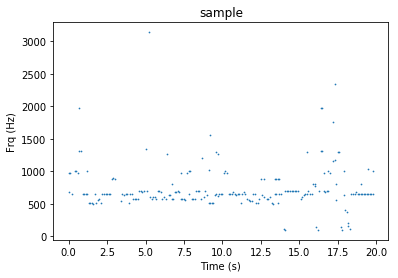

In [427]:
sample_spec = Spectrogram(12000, s_magnitudes)
create_spectrogram("sample", sample_spec.bins)

In [428]:
g = sample_spec.get_addresses()
g

[(Decimal('680.0'), Decimal('660.0'), Decimal('0.2'), Decimal('0.0')),
 (Decimal('680.0'), Decimal('1000.0'), Decimal('0.4'), Decimal('0.0')),
 (Decimal('680.0'), Decimal('1000.0'), Decimal('0.5'), Decimal('0.0')),
 (Decimal('680.0'), Decimal('980.0'), Decimal('0.6'), Decimal('0.0')),
 (Decimal('680.0'), Decimal('1320.0'), Decimal('0.7'), Decimal('0.0')),
 (Decimal('980.0'), Decimal('1000.0'), Decimal('0.4'), Decimal('0.0')),
 (Decimal('980.0'), Decimal('1000.0'), Decimal('0.5'), Decimal('0.0')),
 (Decimal('980.0'), Decimal('980.0'), Decimal('0.6'), Decimal('0.0')),
 (Decimal('980.0'), Decimal('1320.0'), Decimal('0.7'), Decimal('0.0')),
 (Decimal('980.0'), Decimal('1980.0'), Decimal('0.7'), Decimal('0.0')),
 (Decimal('980.0'), Decimal('1000.0'), Decimal('0.4'), Decimal('0.1')),
 (Decimal('980.0'), Decimal('980.0'), Decimal('0.5'), Decimal('0.1')),
 (Decimal('980.0'), Decimal('1320.0'), Decimal('0.6'), Decimal('0.1')),
 (Decimal('980.0'), Decimal('1980.0'), Decimal('0.6'), Decimal('0.1'

In [431]:
hit = 0
miss = 0
for address in sample_spec.get_addresses():
    try:
        p[address]
        print(address, p[address])
        hit += 1
    except:
        miss += 1
print(hit, miss)

(Decimal('660.0'), Decimal('660.0'), Decimal('0.4'), Decimal('10.4')) ('oblivion', 'lily potter')
(Decimal('660.0'), Decimal('660.0'), Decimal('0.3'), Decimal('10.5')) ('oblivion', 'lily potter')
2 953


In [432]:
p

{(Decimal('1380.0'),
  Decimal('120.0'),
  Decimal('1.5'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('1380.0'),
  Decimal('60.0'),
  Decimal('1.7'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('1380.0'),
  Decimal('160.0'),
  Decimal('1.8'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('1380.0'),
  Decimal('80.0'),
  Decimal('2.0'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('1380.0'),
  Decimal('240.0'),
  Decimal('2.8'),
  Decimal('0.0')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('60.0'),
  Decimal('1.1'),
  Decimal('0.6')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('160.0'),
  Decimal('1.2'),
  Decimal('0.6')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('80.0'),
  Decimal('1.4'),
  Decimal('0.6')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('240.0'),
  Decimal('2.2'),
  Decimal('0.6')): ('oblivion', 'lily potter'),
 (Decimal('120.0'),
  Decimal('140.0'),
  Dec

In [433]:
sample_spec.get_addresses()

[(Decimal('680.0'), Decimal('660.0'), Decimal('0.2'), Decimal('0.0')),
 (Decimal('680.0'), Decimal('1000.0'), Decimal('0.4'), Decimal('0.0')),
 (Decimal('680.0'), Decimal('1000.0'), Decimal('0.5'), Decimal('0.0')),
 (Decimal('680.0'), Decimal('980.0'), Decimal('0.6'), Decimal('0.0')),
 (Decimal('680.0'), Decimal('1320.0'), Decimal('0.7'), Decimal('0.0')),
 (Decimal('980.0'), Decimal('1000.0'), Decimal('0.4'), Decimal('0.0')),
 (Decimal('980.0'), Decimal('1000.0'), Decimal('0.5'), Decimal('0.0')),
 (Decimal('980.0'), Decimal('980.0'), Decimal('0.6'), Decimal('0.0')),
 (Decimal('980.0'), Decimal('1320.0'), Decimal('0.7'), Decimal('0.0')),
 (Decimal('980.0'), Decimal('1980.0'), Decimal('0.7'), Decimal('0.0')),
 (Decimal('980.0'), Decimal('1000.0'), Decimal('0.4'), Decimal('0.1')),
 (Decimal('980.0'), Decimal('980.0'), Decimal('0.5'), Decimal('0.1')),
 (Decimal('980.0'), Decimal('1320.0'), Decimal('0.6'), Decimal('0.1')),
 (Decimal('980.0'), Decimal('1980.0'), Decimal('0.6'), Decimal('0.1'